In [5]:
import numpy as np

from keras.models import Sequential
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf

In [8]:
from inception_resnet_v1 import *
model = InceptionResNetV1()

In [9]:
#you can find the model at https://github.com/serengil/tensorflow-101/blob/master/model/facenet_model.json
# model = model_from_json(open("data/facenet_model.json", "r").read())

In [12]:
#you can find the pre-trained weights at https://drive.google.com/file/d/1971Xk5RwedbudGgTIrGAL4F7Aifu7id1/view?usp=sharing
model.load_weights('data/facenet_weights.h5')

#both model and pre-trained weights are inspired from the work of David Sandberg (github.com/davidsandberg/facenet)
#and transformed by Sefik Serengil (sefiks.com)

In [13]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [14]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(160, 160))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [15]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [34]:
metric = "euclidean" #euclidean or cosine

threshold = 0
if metric == "euclidean":
    threshold = 0.15
elif metric == "cosine":
    threshold = 0.07

def verifyFace(img1, img2):
    #produce 128-dimensional representation
    img1_representation = model.predict(preprocess_image('data/train1/%s' % (img1)))[0,:]
    img2_representation = model.predict(preprocess_image('data/train1/%s' % (img2)))[0,:]
    
    if metric == "euclidean":
        img1_representation = l2_normalize(img1_representation)
        img2_representation = l2_normalize(img2_representation)

        euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
        print("euclidean distance (l2 norm): ",euclidean_distance)

        if euclidean_distance < threshold:
            print("Match... they are same person")
        else:
            print("No match! they are not same person!")
            
    elif metric == "cosine":
        cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
        print("cosine similarity: ",cosine_similarity)

        if cosine_similarity < threshold:
            print("Match... they are same person")
        else:
            print("No match! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    
    plt.imshow(image.load_img('data/train1/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('data/train1/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

euclidean distance (l2 norm):  0.45902997
No match! they are not same person!


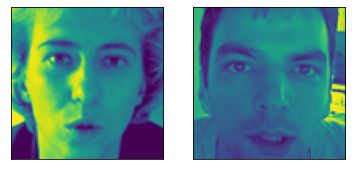

-----------------------------------------
euclidean distance (l2 norm):  0.26134175
No match! they are not same person!


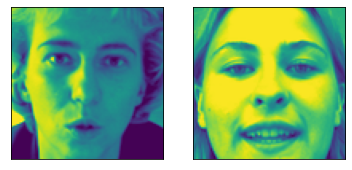

-----------------------------------------


In [35]:
#true positive
verifyFace("1.png", "5.png")
verifyFace("1.png", "7.png")

euclidean distance (l2 norm):  0.37686294
unverified! they are not same person!


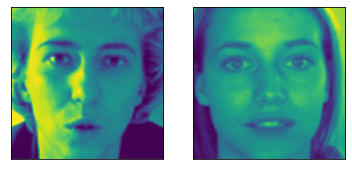

-----------------------------------------
euclidean distance (l2 norm):  0.32856068
unverified! they are not same person!


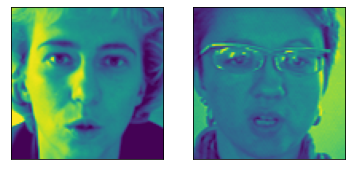

-----------------------------------------


In [30]:
#true negative
verifyFace("1.png", "8.png")
verifyFace("1.png", "10.png")

euclidean distance (l2 norm):  0.34617412
unverified! they are not same person!


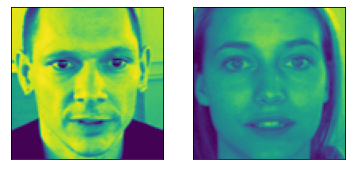

-----------------------------------------
euclidean distance (l2 norm):  0.08433644
verified... they are same person


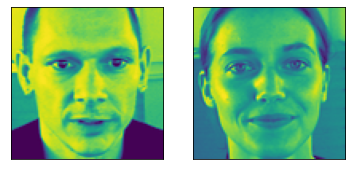

-----------------------------------------


In [31]:
#true positive
verifyFace("17.png", "8.png")
verifyFace("17.png", "9.png")

euclidean distance (l2 norm):  0.2924049
unverified! they are not same person!


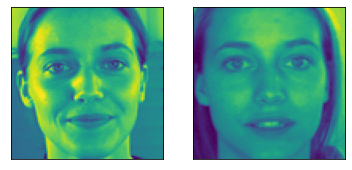

-----------------------------------------
euclidean distance (l2 norm):  0.0
verified... they are same person


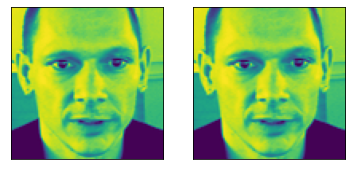

-----------------------------------------


In [32]:
verifyFace("9.png", "8.png")
verifyFace("17.png", "17.png")

In [36]:
import pandas as pd
training = pd.read_csv('data/training.csv')
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [37]:
training.shape

(7049, 31)

In [ ]:
all_imgs = [x for x in range(training.shape[0])]

In [40]:
training['match'][0] = all_imgs.pop()

KeyError: 'match'

In [ ]:
training['match'][0]